# Synthetic Cells Dataset

The image dataset is [BBBC024](https://data.broadinstitute.org/bbbc/BBBC024/) available from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/index.html) ([Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083)).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import tempfile
import shutil

import numpy as np
import tensorflow as tf
#tf.enable_eager_execution()

import tqdm
from skimage import io
from skimage.util import img_as_ubyte
from skimage import exposure
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../../../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Synthetic_Cells")

data_dir = root_dir / "Data"
data_dir.mkdir(parents=True, exist_ok=True)

params = maskflow.load_parameters("parameters.yml")
class_names = params["CLASS_NAMES"]

# Copy config next to data folder
maskflow.save_parameters(params, root_dir / "parameters.yml")

tfrecord_train_writer_path = data_dir / "training_data.tfrecord"
tfrecord_evaluation_writer_path = data_dir / "evaluation_data.tfrecord"

## Download the dataset

In [2]:
# Build the URLs of the dataset

# We download the dataset on a temporary folder since they will be converted to TFRecord
tmp_raw_data_dir = Path(tempfile.mkdtemp())

# [(clustering_probability, SNR), ]
dataset_to_use = [(25, "low"), (25, "high")]

base_url = "https://data.broadinstitute.org/bbbc/BBBC024/"
images_url = []
raw_data_dirs = []
for to_use in dataset_to_use:
    images_url.append(f"{base_url}/BBBC024_v1_c{to_use[0]:02}_{to_use[1]}SNR_images_TIFF.zip")
    raw_data_dirs.append(tmp_raw_data_dir / f"{to_use[0]:02}_{to_use[1]}")
    
# Download the dataset
for image_url, raw_data_dir in zip(images_url, raw_data_dirs):
    if not raw_data_dir.is_dir():
        maskflow.utils.download_zip(image_url, raw_data_dir)

1.81GB [03:36, 9.00MB/s]                            


## Build the dataset

In [ ]:
tfrecord_train_writer = tf.python_io.TFRecordWriter(str(tfrecord_train_writer_path))
tfrecord_evaluation_writer = tf.python_io.TFRecordWriter(str(tfrecord_evaluation_writer_path))
           
training_size = 0.8

image_z_range = [30, 100]

image_id = 0
for image_dir in tmp_raw_data_dir.iterdir():
    print(f"Processing '{image_dir.name}' dataset.")
    
    image_paths = sorted(list(image_dir.glob("*final*.tif")))
    mask_paths = sorted(list(image_dir.glob("*labels*.tif")))
    
    for image_path, mask_path in tqdm.tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
        
        images = io.imread(image_path)
        masks = im = io.imread(mask_path)
        
        for i in range(*image_z_range):
            image = images[i]
            image = exposure.rescale_intensity(image, out_range='uint8')
            image = image.astype("uint8")
            
            image = np.expand_dims(image, axis=-1)
            image = np.tile(image, [1, 1, 3])
            
            mask = masks[i]

            # Build the masks (only one object per frame)
            all_mask = []
            for pixel in np.unique(mask)[1:]:
                single_mask = np.zeros(mask.shape)
                single_mask[mask == pixel] = 1
                all_mask.append(single_mask)
            all_mask = np.array(all_mask)

            class_ids = np.ones([all_mask.shape[0]], dtype=np.int32)

            tf_example = maskflow.create_tf_example(image_id, f"{image_path.stem}_z_{i}", image, all_mask, class_ids)
            image_id += 1
            
            if np.random.rand() < training_size:
                tfrecord_train_writer.write(tf_example.SerializeToString())
            else:
                tfrecord_evaluation_writer.write(tf_example.SerializeToString())
                
tfrecord_train_writer.close()
tfrecord_evaluation_writer.close()

shutil.rmtree(tmp_raw_data_dir)

  0%|          | 0/30 [00:00<?, ?it/s]

Processing '25_high' dataset.


  7%|▋         | 2/30 [01:07<15:48, 33.88s/it]

## Visualize some images with annotations

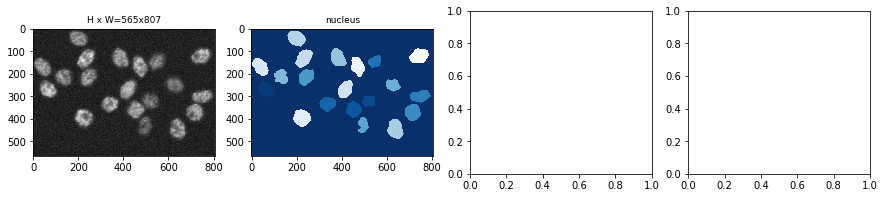

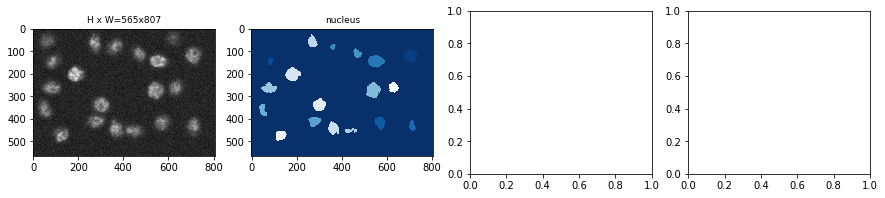

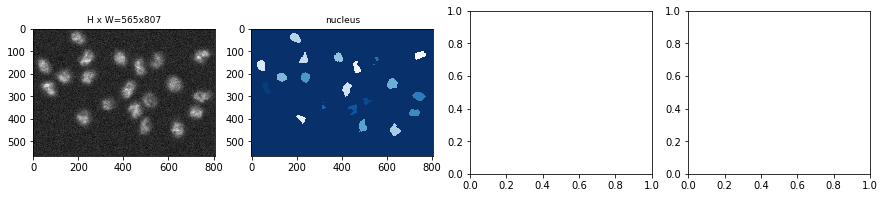

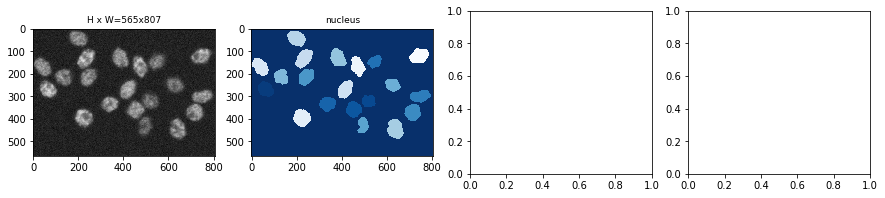

In [39]:
# Retrieve some data
images, annotations = maskflow.get_data(tfrecord_train_writer_path, n=4, shuffle=True)

# Display them
maskflow.batch_display_top_masks(images, annotations["masks"], annotations["class_ids"],
                                 params["CLASS_NAMES"], limit=1, basesize=15)